# Demo:  Polynomial Model Order Selection

In this demo, we will illustrate the process of cross-validation for model order selection.  We demonstrate the concepts via  polynomial fitting using synthetic data.  The lab will demonstrate how to:
* Characterize the model order for a simple polynomial model
* Measure training and test error for a given model order
* Select a suitable model order using cross-validation
* Plot the results for the model order selection process

We first load the packages as usual.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

## Polynomial Data

To illustrate the concepts, we consider a simple polynomial model:
$$
   y = \beta_0 + \beta_1 x + \cdots + \beta_d x^d + \epsilon,
$$
where $d$ is the polynomial degree.  We first generate *synthetic* data for this model.  Sythetic data means that the data was generated artifically (e.g. by a computer program) instead of being actually measured.    

Our synthetic data is going to be generated via the following process:
* Fix a degree 3 polynomial p. Below we choose $p(x) = 1 + .5x + 2x^3$
* Draw each $x_i$ uniformly at random from $[-1,1]$.
* For each $i$ set $y_i = p(x_i) + n_i$ where $n$ is a normal (Gaussian) random variable.

In [2]:
# Import useful polynomial library
import numpy.polynomial.polynomial as poly

# True model parameters
beta = np.array([1,0.5,0,2])   # coefficients
wstd = .5                     # noise
dtrue = len(beta)-1            # true poly degree

# Independent data
nsamp = 100
xdat = np.random.uniform(-1,1,nsamp)

# Polynomial
y0 = poly.polyval(xdat,beta)
ydat = y0 + np.random.normal(0,wstd,nsamp)

If you were given the data, you would first plot the data via a scatter plot like this.

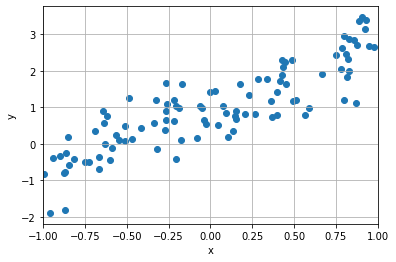

In [3]:
plt.scatter(xdat,ydat)
plt.xlim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

From this plot, you would have to find the relation $y \approx f(x)$.  

In this case, since the data was generated synthetically, we know "true" relation $y = p(x) + \text{noise}$.    The code below plots the true relation on top of the scatter plot.  Of course, for "real" data, we would not know the true relation.  This is the advantage of synthetic data:  you can run a learning algorithm on the data and compare the estimated model to the true function.  

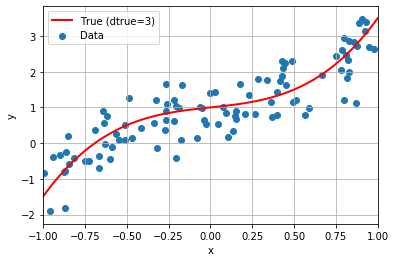

In [4]:
# Plot true function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
plt.xlim(-1,1)
plt.plot(xp,yp,'r-',linewidth=2.0)

# Plot the scatter plot of the measured data
plt.scatter(xdat,ydat)
plt.xlim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['True (dtrue=3)', 'Data'], loc='upper left')
plt.show()

## Fit Model of Different Model Orders

First, suppose that know the true model order  `d=3`, but then didn't know the coefficients of the model. 
As seen in class, we could do this with a data transformation and  multiple linear regression. 

Here we will instead use `sklearn`'s built in `polyfit` command. **There is good reason for this, which Professor Musco is more than am happy to discuss if anyone is interested.** Essentially, while the method discussed in class works in theory, you need to be a bit careful when implementing it on a computer with finite precision arithmetic. If you need to do this for your final project (e.g. because you're using a mix of polynomial features and other non-linear features) talk to me first. 

Text(0, 0.5, 'y')

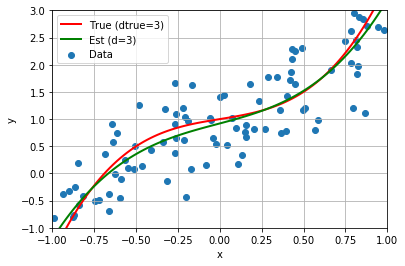

In [5]:
d = 3
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1,1)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=2)
plt.plot(xp,yp_hat,'g-',linewidth=2)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=3)', 'Data'], loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

We see we get an excellent fit to the true function.  

But, in general, the model order `d` is not known.  So, it has to be estimated.   One idea is to use trial and error.  First, suppose we selected a model order that is too low, say $d=1$.

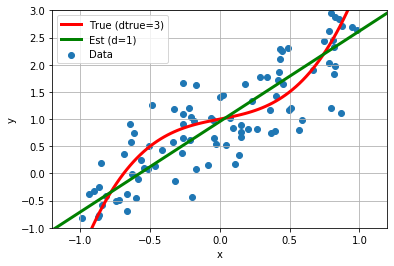

In [6]:
d = 1
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1,1)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=1)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.show()


What we see is called *underfitting*.  The estimated function is not able to capture the full complexity of the relation between $x$ and $y$.  

Now suppose that we tried a model that was very high, say $d=40$. 

**On your own:** Try out different values for the degree `d` here and see what happens. 

/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


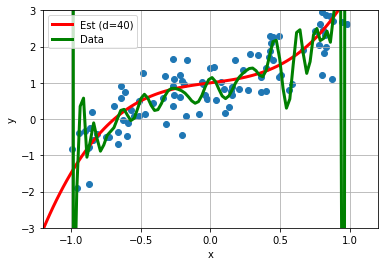

In [7]:
d = 40
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1.2,1.2)
plt.ylim(-3,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['Est (d=40)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.show()

This is called *overfitting* and results is fitting the noise in the data and not the underlying relation $y=f(x)$.

When we compare the estimated function with the true function we can see the overfitting and underfitting clearly.  But, in a real problem, we would not have access to the true function (otherwise, we wouldn't need to be estimating it).  The question then is if we can determine the correct model order from data.  

One (bad) idea is for each model order to  measure the loss (here we use squared loss) on the training data and select $d$ that minimizes the loss.  To do this, the code below loops over a model order `d = 1,2,...,14` and for each model order, fits a model and measures the loss.

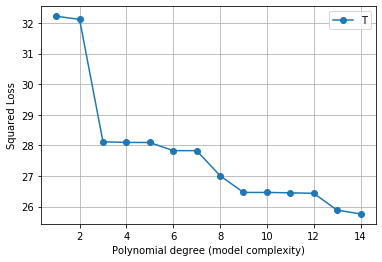

In [8]:
dtest = np.array(range(1,15))
losstr = []
for d in dtest:
    
    # Fit data
    beta_hat = poly.polyfit(xdat,ydat,d)
    
    # Measure Loss on training data
    yhat = poly.polyval(xdat,beta_hat)
    lossd = np.sum((yhat-ydat)**2)
    losstr.append(lossd)
    
plt.plot(dtest,losstr,'o-')
plt.xlabel('Polynomial degree (model complexity)')
plt.ylabel('Squared Loss')
plt.legend(('Train Loss'))
plt.grid()
    

We see that minimizing the Loss on the training data doesn't work:  As we increase $d$, the Loss always decreases.  So minimizing loss on the training data leads to selecting a very high $d$ which in turn results in over-fitting.  How do we avoid this?



## Using Cross-Validation

One simple idea to avoid this issue is cross validation.  We split the data set into two components: (1) training and (2) test.  For now, let us split the data equally between the two parts.

In [9]:
# Number of samples for training and test
ntr = nsamp // 2
nts = nsamp - ntr

# Training
xtr = xdat[:ntr]
ytr = ydat[:ntr]

# Test
xts = xdat[ntr:]
yts = ydat[ntr:]

Before we fit the data, let's plot the training and test samples separately.

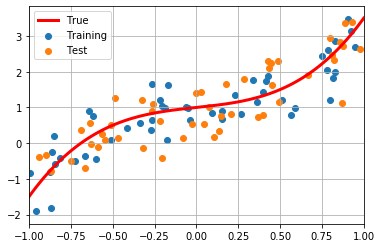

In [10]:
# Plot true function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
plt.xlim(-1,1)
plt.plot(xp,yp,'r-',linewidth=3)

# Plot data
plt.scatter(xtr,ytr)
plt.scatter(xts,yts)
plt.grid()
plt.legend(['True','Training','Test'],loc='upper left')

Now we perform *cross-validation*:  For each model order $d$, we:

* Learn optimal parameters $\hat{\beta}$ of order $d$ on the training data
* Measure $loss_{test}(d)$, the prediction error on the test data.

Select $d$ that minimizes $loss_{test}(d)$.

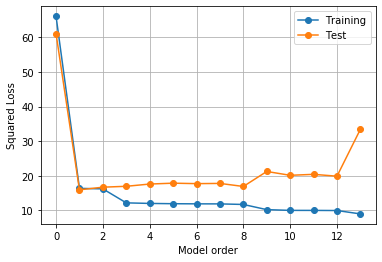

In [11]:
dtest = np.array(range(0,14))
losstest = []
losstr = []
for d in dtest:
    
    # Fit data
    beta_hat = poly.polyfit(xtr,ytr,d)
    
    # Measure squared loss on training data
    # This is not necessary, but we do it just to show the training error
    yhat = poly.polyval(xtr,beta_hat)
    lossd = np.sum((yhat-ytr)**2)
    losstr.append(lossd)
    
    # Measure squared loss on test data
    yhat = poly.polyval(xts,beta_hat)
    lossd = np.sum((yhat-yts)**2)
    losstest.append(lossd)
    
plt.plot(dtest,losstr,'o-')
plt.plot(dtest,losstest,'o-')
plt.xlabel('Model order')
plt.ylabel('Squared Loss')
plt.grid()
plt.legend(['Training','Test'],loc='upper right')
    

We select the model order from the minimum loss on the test data

In [12]:
imin = np.argmin(losstest)
print("Estimated model order= {0:d}".format(dtest[imin]))


Estimated model order= 1


There are a few things to note:
1. If you increase $d$ above even slightly you will see that the test loss quickly sky-rockets. For example try setting `dtest = np.array(range(0,20))`.
2. The test loss actually looks relatively flat between 3 and 10ish. This may seem concerning -- what if the way things worked out (since there's randomness in our data), we chose a model of order 8 or 10 or 12 instead of 3?

Well lets see. Let's try fitting a degree 10 model and plotting the results:

(-4, 4)

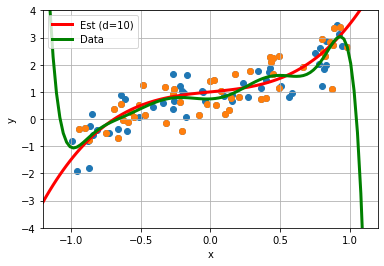

In [13]:
d = 10
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1.2,1.2)
plt.ylim(-3,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.scatter(xts,yts)
plt.legend(['Est (d=10)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.ylim([-4,4])

Even though we did not get the model order 'correct' and the fit degree $10$ polynomial may look slightly different than the true degree $3$ polynomial (especially near the edges of the interval, its still close enough that it will perform nearly as well in prediction for any future data examples.

## K-Fold Validation

There are two potential problems with the simple training / test split in the past example.
* We were only able to use a small number of samples (20 out of 40) for training the model
* The particular model and model order selection depends heavily on the particular samples you chose for the training.

Both of these issues are particularly problematic for data sets with small numbers of samples.  An improvement is to use k-fold validation.  In k-fold validation, we split the data into $k$ parts, each part being approximately equal in size.  In the example below, we will use $k=10$.  For each split, we fit the data on $k-1$ parts and test the data on the remaining part. Then, we average the score over the $k$ parts.  

The `sklearn` package has many routines for this purpose.  We begin by importing the `model_selection` sub-package.

In [14]:
import  sklearn.model_selection 

Then, we run the model validation.  Note that $k$-fold validation can be computationally expensive since we need to iterate over all the folds, and for each fold, we need to iterate over all the model orders.

In [15]:
# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(0,15)
nd = len(dtest)

lossts = np.zeros((nd,nfold))

# Loop over the folds
for isplit, Ind in enumerate(kf.split(xdat)):
        
    # Get the training data in the split
    Itr, Its = Ind 
    #kf.split( ) returns Ind, which contains the indices to the training and testing data for each fold 
    xtr = xdat[Itr]
    ytr = ydat[Itr]
    xts = xdat[Its]
    yts = ydat[Its]
    
    # Loop over the model order
    for it, d in enumerate(dtest):
    
        # Fit data on training data
        beta_hat = poly.polyfit(xtr,ytr,d)
        
        # Measure loss on test data
        yhat = poly.polyval(xts,beta_hat)
        lossts[it,isplit] = np.sum((yhat-yts)**2)


Now, we compute the mean loss over the folds for each model order.

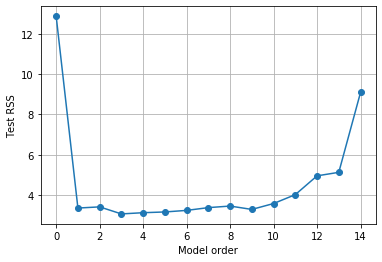

In [16]:
loss_mean = np.mean(lossts,axis=1) #note mean is taken over the second dimension, i.e. all folds for the same model order
plt.plot(dtest, loss_mean, '-o')
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

Again we check which model order achieves the minimum mean loss. For the polynomial problem we won't notice a huge difference in what model order is selected, but for some problems the k-fold cross validation ends up being much more reliable than simple train/test split.

In [17]:
imin = np.argmin(loss_mean)
print("The selected model order is {0:d}".format(dtest[imin]))

The selected model order is 3
